# Coursera Data Science Capstone Project

# === Neighbourhood Analysis of Hamburg, Germany ===

##### Hendrik Welsch, January 2021

## === Part 1 ===

### Generating data frame  of Hamburg, Germany, containing:
   * Neighbourhoods
   * mean rent per square meter in Euro [€/m2]


Installing necessary packages:

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge geopy --yes 

Solving environment: ...working... done

# All requested packages already installed.



Importing necessary packages:

In [3]:
## Calculations and data handling
import pandas as pd # importing pandas for data frame work
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np # library to handle data in a vectorized manner

## Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Geodata
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

## Maps
import folium # map rendering library
import branca

## Foursquare search
import requests # library to handle requests

## Clustering 
from sklearn.cluster import KMeans #import k-means from clustering stage
from sklearn.cluster import AgglomerativeClustering # for hierarchical clustering 
from sklearn.cluster import DBSCAN #for density based clustering
from scipy.spatial import distance_matrix 

I found a website showing all Hamburg neighbourhoods and the associated average rent. Using pandas.read_html, we read all possible tables from the website into a list of data frames:

In [4]:
url = "https://mietspiegeltabelle.de/mietspiegel-hamburg/" # website containing postal codes
dfs = pd.read_html(url) # scrape websites for tables, save them as dataframes to list

Let's check how many data frames were saved:

In [5]:
len(dfs)

1

Let's see how the data frames look:

In [6]:
for i in dfs:
    print(i.shape, "\n", i.head(3),"\n\n")

(104, 2) 
     Stadtteil Miete pro m2
0   Allermöhe    8,70 Euro
1  Alsterdorf   10,72 Euro
2  Altengamme    8,00 Euro 




Let's save it to a new name (HH is the city code of Hamburg, Germany):

In [7]:
df_HH = dfs[0]
df_HH.head(11)

,Stadtteil,Miete pro m2
0,Allermöhe,"8,70 Euro"
1,Alsterdorf,"10,72 Euro"
2,Altengamme,"8,00 Euro"
3,Altenwerder,"9,08 Euro"
4,Altona-Altstadt,"10,60 Euro"
5,Altona-Nord,"10,61 Euro"
6,Bahrenfeld,"10,09 Euro"
7,Barmbek-Nord,"9,47 Euro"
8,Barmbek-Süd,"10,26 Euro"
9,Bergedorf,"8,36 Euro"


"Stadtteil" translates to neighbourhood, while "Miete pro m2" is the mean rent per square meter. Let's translate this to English:

In [8]:
df_HH.rename(columns={"Stadtteil":"Neighbourhood","Miete pro m2":"rent per m2"}, inplace=True)
df_HH.head()

,Neighbourhood,rent per m2
0,Allermöhe,"8,70 Euro"
1,Alsterdorf,"10,72 Euro"
2,Altengamme,"8,00 Euro"
3,Altenwerder,"9,08 Euro"
4,Altona-Altstadt,"10,60 Euro"


Also, for calculations it is necessary to convert the listed rent into floats:

In [9]:
df_HH['rent per m2'] = df_HH['rent per m2'].str.replace(" Euro", '') #remove Euro
df_HH['rent per m2'] = df_HH['rent per m2'].str.replace(",", '.').astype(float) #replace "," with "." and convert to float
df_HH.head()

,Neighbourhood,rent per m2
0,Allermöhe,8.70
1,Alsterdorf,10.72
2,Altengamme,8.00
3,Altenwerder,9.08
4,Altona-Altstadt,10.60


In [10]:
df_HH.dtypes # check if conversion was performed correctly

Neighbourhood     object
rent per m2      float64
dtype: object

There is one location, Neuwerk, which belongs to the city of Hamburg, but is located far away at the coast. 
See google maps: https://www.google.com/maps/dir/Hamburg/Neuwerk/@53.7368883,8.9653513,10z/data=!3m1!4b1!4m13!4m12!1m5!1m1!1s0x47b161837e1813b9:0x4263df27bd63aa0!2m2!1d9.9936819!2d53.5510846!1m5!1m1!1s0x47b41986a0b1134f:0xcfc21f615585970c!2m2!1d8.4973649!2d53.9233455

Since this "neighbourhood" is not of interest to people comparing areas within the city, we remove it from the data frame:

In [11]:
df_HH = df_HH[df_HH["Neighbourhood"] != "Neuwerk"]

In [12]:
df_HH.shape # show dimensions of the dataframe

(103, 2)

#### Ok, so we have a dataframe with 103 neighbourhoods in Hamburg.

## === Part 2 ===

### Next, we need to find the coordinates of each neighbourhood in order to show them on a map! 

We first generate a geolocator object with geopy.
To test whether this worked, we determine the coordinates of Hamburg and show it on a map:

In [13]:
address = 'Hamburg, Germany'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude_HH = location.latitude
longitude_HH = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude_HH, longitude_HH))

The geograpical coordinate of Hamburg are 53.550341, 10.000654.


Using the coordinates, we generate a map of Hamburg with folium:

In [14]:
# create map of Hamburg using latitude and longitude values
map_hamburg = folium.Map(location=[latitude_HH, longitude_HH], zoom_start=11)
map_hamburg

Now, we use a for-loop and geopy to fill lists with the coordinates of each neighbourhood listed in df_HH. Then, those lists are appended to a dataframe df_HH_coord as columns:

In [15]:
neighb = []
coord_lat = []
coord_long = []

for neighbourhood in df_HH["Neighbourhood"]:
    address = '{} ,Hamburg, Germany'.format(neighbourhood)
    
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    neighb.append(neighbourhood)
    coord_lat.append(latitude)
    coord_long.append(longitude)
    
df_HH_coord = pd.DataFrame()       
df_HH_coord["Neighbourhood"] = neighb
df_HH_coord["Latitude"] = coord_lat
df_HH_coord["Longitude"] = coord_long
df_HH_coord.head()
    

,Neighbourhood,Latitude,Longitude
0,Allermöhe,53.483600,10.125000
1,Alsterdorf,53.610541,10.003889
2,Altengamme,53.443796,10.273921
3,Altenwerder,53.504700,9.920560
4,Altona-Altstadt,53.549660,9.945352


In [16]:
df_HH_coord.shape

(103, 3)

Now we use an inner-join approach to join df_HH and df_HH_coords based on "Neighbourhood" and save this to a new dataframe called df_HH_rent_coord:

In [17]:
df_HH_rent_coord = pd.concat([df_HH.set_index("Neighbourhood"), df_HH_coord.set_index("Neighbourhood")], axis=1, join="inner")
df_HH_rent_coord.reset_index(inplace=True)
df_HH_rent_coord.head()

,Neighbourhood,rent per m2,Latitude,Longitude
0,Allermöhe,8.70,53.483600,10.125000
1,Alsterdorf,10.72,53.610541,10.003889
2,Altengamme,8.00,53.443796,10.273921
3,Altenwerder,9.08,53.504700,9.920560
4,Altona-Altstadt,10.60,53.549660,9.945352


In [18]:
df_HH_rent_coord.shape

(103, 4)

In [19]:
df_HH_rent_coord.describe() # show statistics of the dataframe

,rent per m2,Latitude,Longitude
count,103.000000,103.000000,103.000000
mean,9.179806,53.550746,10.010086
std,1.610315,0.066090,0.105396
min,5.790000,53.420677,9.756390
25%,8.020000,53.501642,9.951349
50%,8.920000,53.555066,10.006395
75%,9.885000,53.591672,10.081729
max,14.400000,53.705521,10.273921


### Now that we have the desired dataframe with
  * neighbourhood
  * rent
  * coordinates

### ... we can next plot the neighbourhoods on the Hamburg map. 
#### Moreover, I want to group the neighbourhoods by mean rent and show different groups in different colors.
As thresholds, I chose the quantiles (25%, 75% values in the dataframe description above). So lets save those values to variables called "cheap" and "expensive". I also want to show the neighbourhoods with lowest (minrent) and highest (maxrent) rent:

In [20]:
# saving threshold values to variables
cheap = df_HH_rent_coord["rent per m2"].quantile(0.25)
expensive = df_HH_rent_coord["rent per m2"].quantile(0.75)
maxrent = df_HH_rent_coord["rent per m2"].max()
minrent = df_HH_rent_coord["rent per m2"].min()
print(minrent, cheap, expensive, maxrent)

5.79 8.02 9.885 14.4


We generate the map of Hamburg and populate it with the markers and a legend:

In [124]:
# generate map
map_hamburg = folium.Map(location=[latitude_HH, longitude_HH], zoom_start=10)

# populate with markers
for lat, lng, neighborhood, rent in zip(df_HH_rent_coord['Latitude'], df_HH_rent_coord['Longitude'], df_HH_rent_coord['Neighbourhood'], df_HH_rent_coord['rent per m2']):
    label = '{} ({} €/m2)'.format(neighborhood, rent)
    label = folium.Popup(label, parse_html=True)
    
    # marker color based on rent
    if rent <= minrent:
        c = "green"
    elif rent >= maxrent:
        c = "red"
    elif rent <= cheap:
        c = "blue"
    elif rent >= expensive:
        c = "orange"
    else:
        c = "gray"
    # marker design
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  

# adding color legend with branca.colormap    
colormap = branca.colormap.LinearColormap(colors=["green", "blue", "gray", "orange", "red"])
colormap = colormap.to_step(index=[minrent-1, minrent, cheap, expensive, maxrent, maxrent+1])
colormap.caption = 'Mean rent/m2 [€] in Hamburg Neighbourhoods (2017)'
colormap.add_to(map_hamburg)
    
map_hamburg

### Analysis:
Neighbourhoods closer to the city center around north/northwest of river Elbe show higher rents (orange markers), with the highest rent for HafenCity (= harbour city center district). Neighbourhoods farther out show medium (gray markers) rent north of the river, while parts south of the river contain a lot of neighbourhoods with cheap rent (blue), including the neighbourhood with lowest rent in Hamburg (Moorburg).

## === Part 3 ===

### Next, we want to use Foursquare data to retrieve popular venues for each neighbourhood

To use the Foursquare API, I have to enter my credentials (CLIENT_ID, CLIENT_SECRET). For security reasons, the cell containing this data was removed after running the notebook

Then we add the version number, a limit for search queries and a radius to search around the POIs

In [23]:
VERSION = '20200116' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 600 # radius in meters around location

Let's see how the data looks that we retrieve from Foursquare, here for the HafenCity neighbourhood:

In [24]:
neighbourhood = "HafenCity"
lat_check = df_HH_rent_coord["Latitude"][int(df_HH_rent_coord.index[df_HH_rent_coord["Neighbourhood"] == neighbourhood][0])]
lng_check = df_HH_rent_coord["Longitude"][int(df_HH_rent_coord.index[df_HH_rent_coord["Neighbourhood"] == neighbourhood][0])]

print("Coordinates of {} in Hamburg are {}, {}.".format(neighbourhood, lat_check, lng_check))

Coordinates of HafenCity in Hamburg are 53.5429127, 9.9958346.


We generate a URL with all necessary data to run a search query from Foursquare with "request":

In [25]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_check, 
            lng_check, 
            RADIUS, 
            LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '600d9ead5428e13b7686abba'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'HafenCity',
  'headerFullLocation': 'HafenCity, Hamburg',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 70,
  'suggestedBounds': {'ne': {'lat': 53.54831270540001,
    'lng': 10.00490517641926},
   'sw': {'lat': 53.5375126946, 'lng': 9.98676402358074}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b05885cf964a520cec022e3',
       'name': 'Speicherstadt',
       'location': {'lat': 53.5443111337923,
        'lng': 9.99481201171875,
        'labeledLatLngs': [{'label': 'display',
          'lat': 53.5443111337923,
          'lng': 9.99481201171875}],


#### The data that we are interested in is located under response > groups > items. Each item contains information about the venue:
  * name: the name of the venue
  * coordinates (lat, lng)
  * categories: information about venue category

#### I noticed, that the category names are quite specific, resulting in a lot of unique category names. To get a somewhat more general venue category of each venue (and thus reducing number of unique categories), we can also retrieve elements from the URL that is stored in "icon" > "prefix":
It looks like this:

```
'name':
'Supermarket','pluralName': 'Supermarkets','shortName': 'Supermarket',
         'icon':{'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_'
```
         
As you can see, while the venue is categorized as "Supermarket", the URL groups it into "food_grocery" and then under "shops".

#### I have decided to retrieve all three types of categories from  the request data. They will be referred to as follows:
  * "Venue Category", retrieved from "name"
  * "Higher Category", the last part of the URL (i.e., food_grocery)
  * "Highest Category", the second-to-last part of the URL (i.e., shops)

#### Now we generate a function to pull popular venues for each neighbourhood. The following function pulls the top 100 (or whatever LIMIT is set to) venues around a location (neighbourhood) and saves it to a dataframe:

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(pc, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue and append to venue list
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'], 
            v['venue']['categories'][0]['icon']['prefix'].split("/")[-1],
            v['venue']['categories'][0]['icon']['prefix'].split("/")[-2]) for v in results])

    #generate dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Higher Category', 'Highest Category']
    
    return(nearby_venues)

#### Now we run the above function with the Hamburg data as input:

In [27]:
hamburg_venues = getNearbyVenues(
    names=df_HH_rent_coord["Neighbourhood"],
    latitudes=df_HH_rent_coord["Latitude"],
    longitudes=df_HH_rent_coord["Longitude"], 
    radius=RADIUS)

In [28]:
hamburg_venues.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Higher Category,Highest Category
0,Alsterdorf,53.610541,10.003889,Eppendorfer Moor,53.613315,10.002277,Nature Preserve,naturepreserve_,parks_outdoors
1,Alsterdorf,53.610541,10.003889,REWE,53.607647,10.005769,Supermarket,food_grocery_,shops
2,Alsterdorf,53.610541,10.003889,Braband,53.613330,10.002281,Café,cafe_,food
3,Alsterdorf,53.610541,10.003889,Best Western Premier Alsterkrug Hotel,53.613080,9.999037,Hotel,hotel_,travel
4,Alsterdorf,53.610541,10.003889,Eiskaffee Eis Perle,53.608354,10.009394,Ice Cream Shop,icecream_,food


#### Lets have a look at how many unique category types there are on the different category levels:

In [29]:
print('There are \n{} unique venue categories, \n{} unique higher-level categories, and \n{} highest-level categories.'.format(
    len(hamburg_venues['Venue Category'].unique()), 
    len(hamburg_venues['Higher Category'].unique()),
    len(hamburg_venues['Highest Category'].unique())
     ))

There are 
267 unique venue categories, 
189 unique higher-level categories, and 
7 highest-level categories.


Let's have a closer look at the unique categories in "Venue Categories":

In [30]:
hamburg_venues['Venue Category'].unique()

array(['Nature Preserve', 'Supermarket', 'Café', 'Hotel',
       'Ice Cream Shop', 'Greek Restaurant', 'Diner', 'Bus Stop',
       'Bridge', 'Park', 'Asian Restaurant', 'Pet Store', 'Salad Place',
       'Bakery', 'Vietnamese Restaurant', 'Drugstore', 'Doner Restaurant',
       'Turkish Restaurant', 'Sports Club', 'Furniture / Home Store',
       'Pub', 'Clothing Store', 'Performing Arts Venue',
       'Seafood Restaurant', 'Arcade', 'Mexican Restaurant',
       'Gourmet Shop', 'Grocery Store', 'Steakhouse',
       'Italian Restaurant', 'Taverna', 'Burger Joint', 'Wine Bar',
       'Ramen Restaurant', 'Thai Restaurant', 'Organic Grocery',
       'Electronics Store', 'Gym / Fitness Center', 'Hot Dog Joint',
       'Food & Drink Shop', 'Pizza Place', 'Market', 'Farmers Market',
       'German Restaurant', 'Venezuelan Restaurant', 'Bar', 'Comedy Club',
       'Theater', 'Nightclub', 'Indian Restaurant', 'French Restaurant',
       'Restaurant', 'Brewery', 'Street Food Gathering', 'Big Box

Most of these categories are venues of interest for someone to have in the vincinity of their appartment. However, some categories might skew with our clustering approach later on: Mainly, these categories are transport locations such as "Bus Stop" and "Road". Although it is nice to have a good connection to public transport, it is often not the deciding factor when choosing a neighbourhood since public transport connection in german cities is generally very good. 

I have therefore decided to drop entries from those categories:

In [31]:
to_drop = ["Bus Stop", "Bridge", "Intersection", "Light Rail Station", "Metro Station", "Road", "Train Station", "Bus Station"]

for i in to_drop:
    hamburg_venues = hamburg_venues[hamburg_venues["Venue Category"] != i]

In [32]:
print('There are \n{} unique venue categories, \n{} unique higher-level categories, and \n{} highest-level categories.'.format(
    len(hamburg_venues['Venue Category'].unique()), 
    len(hamburg_venues['Higher Category'].unique()),
    len(hamburg_venues['Highest Category'].unique())
     ))

There are 
259 unique venue categories, 
184 unique higher-level categories, and 
7 highest-level categories.


### Analysis:
After removing transport categories, retrieving higher-level venue categories reduced the number of unique categories by about 29 % from 259 to 184. We will later compare category collections in a clustering approach. The number of highest-level categories is very low (97 % reduction) and very generalized. However, for some stakeholders it might be interesting to get a very generalized overview of Hamburg.

## === Part 4 ===

### Clustering of Hamburg Neighbourhoods based on Popular Venues using Machine Learning
#### Aim: We want to cluster the neighbourhoods in Hamburg using the retrieved venue data. Here, we want to compare different levels of venue category detail

Using one hot encoding, we generate data frames with all collected venue categories as column labels. This is done for all three levels of venue categories separately:

In [33]:
# one hot encoding
hamburg_onehot1 = pd.get_dummies(hamburg_venues[['Venue Category']], prefix="", prefix_sep="")
hamburg_onehot2 = pd.get_dummies(hamburg_venues[['Higher Category']], prefix="", prefix_sep="")
hamburg_onehot3 = pd.get_dummies(hamburg_venues[['Highest Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hamburg_onehot1['Neighbourhood'] = hamburg_venues['Neighbourhood']
hamburg_onehot2['Neighbourhood'] = hamburg_venues['Neighbourhood']
hamburg_onehot3['Neighbourhood'] = hamburg_venues['Neighbourhood']

# move neighborhood column to the first column
fixed_columns1 = [hamburg_onehot1.columns[-1]] + list(hamburg_onehot1.columns[:-1])
hamburg_onehot1 = hamburg_onehot1[fixed_columns1]

fixed_columns2 = [hamburg_onehot2.columns[-1]] + list(hamburg_onehot2.columns[:-1])
hamburg_onehot2 = hamburg_onehot2[fixed_columns2]

fixed_columns3 = [hamburg_onehot3.columns[-1]] + list(hamburg_onehot3.columns[:-1])
hamburg_onehot3 = hamburg_onehot3[fixed_columns3]

In [34]:
hamburg_onehot1.head() # contains all detailed venue categories

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Business Service,Café,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Lake,Laundromat,Lebanese Restaurant,Lighthouse,Lighting Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Optical Shop,Organic Grocery,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Palatine Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Trattoria/Osteria,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [35]:
hamburg_onehot2.head() # contains all higher-level categories

,Neighbourhood,afghan_,airport_rentalcar_,apparel_,apparel_accessories_,apparel_boutique_,apparel_men_,apparel_shoestore_,arcade_,arepas_,argentinian_,artgallery_,artstore_,asian_,austrian_,automotive_,bagels_,bakery_,baseballfield_,basketballcourt_,bbqalt_,beach_,beauty_cosmetic_,bedandbreakfast_,beergarden_,bikeshop_,billiards_,boat_,bookstore_,breakfast_,brewery_,bridge_,bubble_,burger_,burrito_,cafe_,camerastore_,candystore_,cocktails_,coffeeshop_,comedyclub_,conveniencestore_,cupcakes_,default_,deli_,departmentstore_,design_,dessert_,dimsum_,diner_,discountstore_,divebar_,donuts_,eventspace_,falafel_,fastfood_,ferry_pier_,field_,financial_,fishandchips_,fleamarket_,flowershop_,food_butcher_,food_cheese_,food_farmersmarket_,food_fishmarket_,food_foodcourt_,food_gourmet_,food_grocery_,food_liquor_,food_wineshop_,foodanddrink_,french_,friedchicken_,furniture_,garden_,gas_,gastropub_,gaybar_,german_,giftshop_,golfcourse_,government_monument_,greek_,gym_,gym_martialarts_,gym_yogastudio_,halal_,harbor_,hardware_,hikingtrail_,hobbyshop_,hookahbar_,hostel_,hotdog_,hotel_,hotel_bar_,icecream_,indian_,indonesian_,italian_,japanese_,korean_,lake_,laundry_,lighthouse_,mall_,market_,medical_,medical_opticalshop_,mediterranean_,mexican_,middleeastern_,mobilephoneshop_,motorcycle_,movietheater_,museum_,museum_art_,museum_history_,museum_planetarium_,music_instruments_,musicvenue_,musicvenue_jazzclub_,musicvenue_rockclub_,naturepreserve_,neighborhood_,nightclub_,paella_,papergoods_,park_,performingarts_,performingarts_dancestudio_,performingarts_theater_,pet_store_,pharmacy_,piercing_,pizza_,playground_,plaza_,pool_,portuguese_,pub_,racetrack_,ramen_,realestate_,record_shop_,religious_church_,restarea_,river_,salad_,salon_barber_,scandinavian_,sceniclookout_,sculpture_,seafood_,skate_park_,snacks_,soup_,souvlaki_,spa_,spanish_,sports_outdoors_,stable_,stadium_basketball_,stadium_hockey_,stadium_soccer_,stadium_tennis_,stadium_track_,steakhouse_,streetfood_,sushi_,tanning_salon_,tapas_,tearoom_,technology_,thai_,tobacco_,toys_,turkish_,vegetarian_,vietnamese_,waterpark_,whiskey_,winery_,zoo_
0,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alsterdorf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [36]:
hamburg_onehot3.head() # contains all highest-level categories

,Neighbourhood,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel
0,Alsterdorf,0,0,0,0,1,0,0
1,Alsterdorf,0,0,0,0,0,1,0
2,Alsterdorf,0,0,1,0,0,0,0
3,Alsterdorf,0,0,0,0,0,0,1
4,Alsterdorf,0,0,1,0,0,0,0


In [37]:
print("The dimensions of the three dataframes are as follows:\n Venue Categories {}\n Higher Category {}\n Highest Category {}".format(
    hamburg_onehot1.shape, hamburg_onehot2.shape, hamburg_onehot3.shape))

The dimensions of the three dataframes are as follows:
 Venue Categories (1863, 260)
 Higher Category (1863, 185)
 Highest Category (1863, 8)


#### Now we generate a new data frame containing grouped data

In [38]:
hamburg_grouped1 = hamburg_onehot1.groupby('Neighbourhood').mean().reset_index()
hamburg_grouped2 = hamburg_onehot2.groupby('Neighbourhood').mean().reset_index()
hamburg_grouped3 = hamburg_onehot3.groupby('Neighbourhood').mean().reset_index()

In [39]:
print("The dimensions of the three dataframes are as follows:\n Venue Categories {}\n Higher Category {}\n Highest Category {}".format(
    hamburg_grouped1.shape, hamburg_grouped2.shape, hamburg_grouped3.shape))

The dimensions of the three dataframes are as follows:
 Venue Categories (95, 260)
 Higher Category (95, 185)
 Highest Category (95, 8)


...note that we have less rows (= neighbourhoods) than in the beginning. That is because for some neighbourhoods, the foursquare search did not come up with any venues, and thus they are lost during one-hot encoding. This might change if  the search radius is increased (currently = 600), however, for this project we will leave it at 600.

Next, we will define a function to return the top venue categories per location and run it for every location. The result is a data frame.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
## set-up for dataframe generation
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ["Neighbourhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [42]:
# create new dataframe with top venue categories
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1["Neighbourhood"] = hamburg_grouped1["Neighbourhood"]

for ind in np.arange(hamburg_grouped1.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted1.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alsterdorf,Asian Restaurant,Hotel,Pet Store,Supermarket,Bakery
1,Altona-Altstadt,Café,Pub,Hotel,Furniture / Home Store,Supermarket
2,Altona-Nord,Hotel,Nightclub,Supermarket,Park,Bakery
3,Bahrenfeld,Ice Cream Shop,Cocktail Bar,Wine Shop,Pharmacy,Cosmetics Shop
4,Barmbek-Nord,Supermarket,Italian Restaurant,Plaza,Bakery,Hotel


In [43]:
# create new dataframe with top venue categories, higher level
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2["Neighbourhood"] = hamburg_grouped2["Neighbourhood"]

for ind in np.arange(hamburg_grouped2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alsterdorf,food_grocery_,asian_,pet_store_,hotel_,bakery_
1,Altona-Altstadt,food_grocery_,hotel_,pub_,cafe_,pharmacy_
2,Altona-Nord,default_,nightclub_,hotel_,pharmacy_,park_
3,Bahrenfeld,default_,food_grocery_,italian_,pharmacy_,beauty_cosmetic_
4,Barmbek-Nord,food_grocery_,asian_,plaza_,italian_,bakery_


In [44]:
# create new dataframe with top venue categories, highest level
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3["Neighbourhood"] = hamburg_grouped3["Neighbourhood"]

for ind in np.arange(hamburg_grouped3.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped3.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted3.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alsterdorf,food,shops,travel,parks_outdoors,nightlife
1,Altona-Altstadt,food,shops,travel,nightlife,arts_entertainment
2,Altona-Nord,food,shops,parks_outdoors,nightlife,travel
3,Bahrenfeld,shops,food,parks_outdoors,nightlife,travel
4,Barmbek-Nord,food,shops,parks_outdoors,travel,arts_entertainment


###  == Part 4.1 -- K-means Clustering ==

#### To cluster the neighborhoods, we generate a k means model and label the locations based on their cluster.

First, let's determine the optimal k value for each data set. Because we need to do this for three data frames, we write a function:

In [45]:
def optimalK(df, name, a, b):

    distortions = []
    K = range(a,b)

    for k in K: 
        clustering = df.drop('Neighbourhood', 1)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(clustering)
        distortions.append(kmeans.inertia_)

    plt.plot(K, distortions)
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for {}'.format(name))
    plt.show()

... and run it for ks 1 to 15

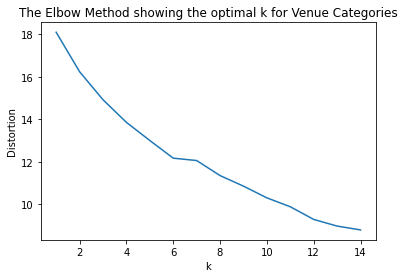

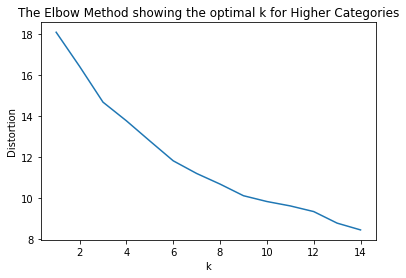

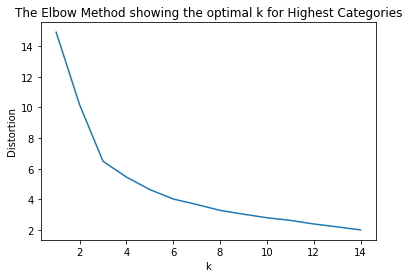

In [46]:
optimalK(hamburg_grouped1, "Venue Categories", 1, 15)
optimalK(hamburg_grouped2, "Higher Categories", 1, 15)
optimalK(hamburg_grouped3, "Highest Categories", 1, 15)

### Analysis:
Overall the distortion value decreases with increasing k. 

The optimal k is where the curve makes a sharp turn / bend, resulting in an elbow-like shape (more on this here: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). This is only in part true for the Highest Category data with a bend at k=3, which will be chosen for the highest-level venue categories. 

We will carry on using k=6 for the other two data sets, since this seems to be a good compromise between low distortion and small number of clusters.

In [47]:
# function to cluster the neighbourhoods in the dataframe
def clusterKmeans(df, k):

    kmeans = KMeans(n_clusters=k, random_state=0).fit(df.drop('Neighbourhood', 1))
    
    return kmeans    

In [48]:
# run function for all three dataframes with pre-determined k
kmeans1 = clusterKmeans(hamburg_grouped1, 6)
kmeans2 = clusterKmeans(hamburg_grouped2, 6)
kmeans3 = clusterKmeans(hamburg_grouped3, 3)

In [49]:
# checking if labelling worked
print(kmeans1.labels_[0:10],kmeans2.labels_[0:10],kmeans3.labels_[0:10] )

[5 5 5 5 5 0 5 0 5 4] [4 4 4 4 4 0 4 0 4 4] [2 0 0 0 2 0 0 0 2 0]


In [50]:
# add clustering labels to dataframes
neighborhoods_venues_sorted1.insert(0, 'Cluster Labels', kmeans1.labels_)
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans2.labels_)
neighborhoods_venues_sorted3.insert(0, 'Cluster Labels', kmeans3.labels_)

hamburg_merged = df_HH_rent_coord

In [51]:
# merge hamburg_grouped with neighborhoods_venues_sorted1-3 to add latitude/longitude for each postal code area
hamburg_merged1 = hamburg_merged.join(neighborhoods_venues_sorted1.set_index('Neighbourhood'), on='Neighbourhood')
hamburg_merged2 = hamburg_merged.join(neighborhoods_venues_sorted2.set_index('Neighbourhood'), on='Neighbourhood')
hamburg_merged3 = hamburg_merged.join(neighborhoods_venues_sorted3.set_index('Neighbourhood'), on='Neighbourhood')

In [52]:
hamburg_merged1.head()

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allermöhe,8.70,53.483600,10.125000,NaN,NaN,NaN,NaN,NaN,NaN
1,Alsterdorf,10.72,53.610541,10.003889,5.0,Asian Restaurant,Hotel,Pet Store,Supermarket,Bakery
2,Altengamme,8.00,53.443796,10.273921,NaN,NaN,NaN,NaN,NaN,NaN
3,Altenwerder,9.08,53.504700,9.920560,NaN,NaN,NaN,NaN,NaN,NaN
4,Altona-Altstadt,10.60,53.549660,9.945352,5.0,Café,Pub,Hotel,Furniture / Home Store,Supermarket


In [53]:
hamburg_merged2.head()

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allermöhe,8.70,53.483600,10.125000,NaN,NaN,NaN,NaN,NaN,NaN
1,Alsterdorf,10.72,53.610541,10.003889,4.0,food_grocery_,asian_,pet_store_,hotel_,bakery_
2,Altengamme,8.00,53.443796,10.273921,NaN,NaN,NaN,NaN,NaN,NaN
3,Altenwerder,9.08,53.504700,9.920560,NaN,NaN,NaN,NaN,NaN,NaN
4,Altona-Altstadt,10.60,53.549660,9.945352,4.0,food_grocery_,hotel_,pub_,cafe_,pharmacy_


In [54]:
hamburg_merged3.head()

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allermöhe,8.70,53.483600,10.125000,NaN,NaN,NaN,NaN,NaN,NaN
1,Alsterdorf,10.72,53.610541,10.003889,2.0,food,shops,travel,parks_outdoors,nightlife
2,Altengamme,8.00,53.443796,10.273921,NaN,NaN,NaN,NaN,NaN,NaN
3,Altenwerder,9.08,53.504700,9.920560,NaN,NaN,NaN,NaN,NaN,NaN
4,Altona-Altstadt,10.60,53.549660,9.945352,0.0,food,shops,travel,nightlife,arts_entertainment


#### As mentioned earlier, there are some areas without any venues which only contain NaN in the table. Let's see what data we have retrieved from foursquare for one of these neighbourhoods:

In [55]:
neighbourhood = "Allermöhe"
lat_check = df_HH_rent_coord["Latitude"][int(df_HH_rent_coord.index[df_HH_rent_coord["Neighbourhood"] == neighbourhood][0])]
lng_check = df_HH_rent_coord["Longitude"][int(df_HH_rent_coord.index[df_HH_rent_coord["Neighbourhood"] == neighbourhood][0])]

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_check, 
            lng_check, 
            RADIUS, 
            LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '600d9ed35237b50080dbf9fb'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Allermöhe',
  'headerFullLocation': 'Allermöhe, Hamburg',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 0,
  'suggestedBounds': {'ne': {'lat': 53.48900000540001,
    'lng': 10.134057889462964},
   'sw': {'lat': 53.4781999946, 'lng': 10.115942110537036}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': []}]}}

#### Note the warning:
```'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."```

#### It seems that there are no popular venues in these areas. Lets drop the rows with NaN:

In [56]:
hamburg_merged1.dropna(subset=["Cluster Labels"], inplace=True)
hamburg_merged2.dropna(subset=["Cluster Labels"], inplace=True)
hamburg_merged3.dropna(subset=["Cluster Labels"], inplace=True)

In [57]:
# checking if there are any NaN or other unwanted labels remaining in the cluster label column
print(hamburg_merged1["Cluster Labels"].unique(), 
      hamburg_merged2["Cluster Labels"].unique(),
      hamburg_merged3["Cluster Labels"].unique())

[5. 0. 4. 2. 1. 3.] [4. 0. 2. 1. 5. 3.] [2. 0. 1.]


... now there are only clustered areas left in the data frame!

### == Part 4.2 -- Showing clustered data on map ==
#### We can now use folium to add the locations to a map of Hamburg, where the locations is colored based on its cluster.
#### Please note: 
Clusters are  coloured based number of neighbourhoods from biggest (black) to smallest (red). The size of the circle markers represents 600 m on the map.

In [58]:
# function to create map
def mapHamburg(df):

    map_clusters = folium.Map(location=[latitude_HH, longitude_HH], zoom_start=10)

    # set color scheme for the clusters
    alt_colors = ["black", "blue", "green", "purple", "orange", "red"]

    # ordering cluster IDs by counts per cluster
    cluster_ordered = []
    cluster_counts = df.iloc[
        df.groupby('Cluster Labels')['Cluster Labels'].transform('size').mul(-1).argsort(kind='mergesort')]
    for i in cluster_counts["Cluster Labels"].unique():
        cluster_ordered.append(i)
    
    
    # add markers to the map
    markers_colors = []
    for lat, lon, neigh, cluster, in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Neighbourhood'], 
        df['Cluster Labels'], 
        ):
    
        label = folium.Popup(str(neigh) + ' (Cluster ' + str(int(cluster)) + ')', parse_html=True)
        folium.Circle(
            [lat, lon],
            radius=RADIUS,
            popup=label,
            color=alt_colors[int(cluster_ordered.index(cluster))],
            fill=True,
            fill_color=alt_colors[int(cluster_ordered.index(cluster))],
            fill_opacity=0.3).add_to(map_clusters)
       
    return map_clusters

Before we generate the maps, we also define some functions to show the clusters as a table and analyze the clusters regarding top venues:

In [59]:
# show dataframe that only contains rows of the given cluster
def clusterAnalysis(df, cluster_id):
    df = df.loc[df["Cluster Labels"] == cluster_id]
    return df

In [60]:
# sort the clusters based on their size
def sortByClusterCount(df, name):
    cluster_ordered = []
    cluster_counts = df.iloc[
        df.groupby('Cluster Labels')['Cluster Labels'].transform('size').mul(-1).argsort(kind='mergesort')]  
    for i in cluster_counts["Cluster Labels"].unique():
        cluster_ordered.append(i)
    print("The ranked order of clusters in dataframe {} is {}".format(name, cluster_ordered))
    return cluster_ordered
   
    

In [61]:
# show top venues per cluster
def topVenueCategories(df, cluster, n=5):
    v = ["1st", "2nd", "3rd", "4th", "5th"]
    df_1 = df["1st Most Common Venue"].loc[df["Cluster Labels"]==cluster].value_counts()
    df_2 = df["2nd Most Common Venue"].loc[df["Cluster Labels"]==cluster].value_counts()
    df_3 = df["3rd Most Common Venue"].loc[df["Cluster Labels"]==cluster].value_counts()
    print("Top categories are:\n","\n\n1st Most Common Venue \n",
          df_1[0:n],
          "\n\n2nd Most Common Venue \n",
          df_2[0:n-1],"\n\n3rd Most Common Venue \n",
          df_3[0:n-2])

In [62]:
# plot bar graph showing mean rent +/- standard deviation for each cluster
def clusterMeanRent(df, cluster_ordered, label):
    
    mean_rent = []
    std = []
    
      
    for cluster in cluster_ordered:
        print("Mean rent of cluster {} ({} neighbourhoods): ".format(
            cluster, 
            df[label].loc[df[label]==cluster].count()),
            
            round(df["rent per m2"].loc[df[label]==cluster].mean(),2),
            "+/-" ,
            round(df["rent per m2"].loc[df[label]==cluster].std(),2), 
            "[€]")
        mean_rent.append(df["rent per m2"].loc[df[label]==cluster].mean())
        std.append(df["rent per m2"].loc[df[label]==cluster].std())
        
    fig, ax = plt.subplots()
    ax.bar(cluster_ordered, mean_rent, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('mean rent/m2 [€]')
    ax.set_xticks(cluster_ordered)
    ax.set_xticklabels(cluster_ordered)
    ax.set_title('Mean rent/m2 [€] of Hamburg Clusters')
    ax.yaxis.grid(True)

    plt.show()
        

### === 4.2.1 -- Cluster analysis for detailed venue categories ===

In [63]:
mapHamburg(hamburg_merged1)

Determine order of clusters from biggest to smallest:

In [64]:
clusters1_sorted = sortByClusterCount(hamburg_merged1, "hamburg_merged1")

The ranked order of clusters in dataframe hamburg_merged1 is [5.0, 0.0, 4.0, 2.0, 1.0, 3.0]


Mean rent of cluster 5.0 (65 neighbourhoods):  9.63 +/- 1.71 [€]
Mean rent of cluster 0.0 (20 neighbourhoods):  8.8 +/- 1.02 [€]
Mean rent of cluster 4.0 (6 neighbourhoods):  7.87 +/- 0.47 [€]
Mean rent of cluster 2.0 (2 neighbourhoods):  6.07 +/- 0.4 [€]
Mean rent of cluster 1.0 (1 neighbourhoods):  8.88 +/- nan [€]
Mean rent of cluster 3.0 (1 neighbourhoods):  8.95 +/- nan [€]


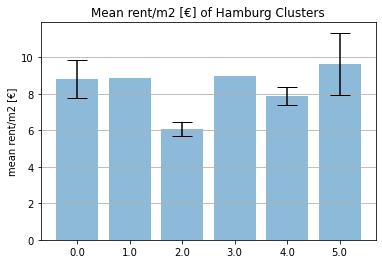

In [65]:
clusterMeanRent(hamburg_merged1, clusters1_sorted, "Cluster Labels")

#### Let's go through the clusters one by one from biggest to smallest:

In [66]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[0]) # black

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Alsterdorf,10.72,53.610541,10.003889,5.0,Asian Restaurant,Hotel,Pet Store,Supermarket,Bakery
4,Altona-Altstadt,10.60,53.549660,9.945352,5.0,Café,Pub,Hotel,Furniture / Home Store,Supermarket
5,Altona-Nord,10.61,53.561400,9.944720,5.0,Hotel,Nightclub,Supermarket,Park,Bakery
6,Bahrenfeld,10.09,53.569070,9.905583,5.0,Ice Cream Shop,Cocktail Bar,Wine Shop,Pharmacy,Cosmetics Shop
7,Barmbek-Nord,9.47,53.598894,10.048100,5.0,Supermarket,Italian Restaurant,Plaza,Bakery,Hotel
9,Bergedorf,8.36,53.483838,10.210047,5.0,Pet Store,Clothing Store,Trattoria/Osteria,Supermarket,Electronics Store
11,Billbrook,8.38,53.527507,10.086782,5.0,Café,Hotel,BBQ Joint,Zoo Exhibit,Fast Food Restaurant
13,Billwerder,7.82,53.499188,10.134611,5.0,Baseball Field,Soccer Field,Gastropub,Zoo Exhibit,Fish Market
14,Blankenese,12.19,53.557500,9.803060,5.0,Seafood Restaurant,Café,Hotel,Restaurant,Neighborhood
15,Borgfelde,9.34,53.555029,10.033300,5.0,Hotel,Bakery,Bagel Shop,Furniture / Home Store,Food


In [67]:
topVenueCategories(hamburg_merged1, clusters1_sorted[0])

Top categories are:
 

1st Most Common Venue 
 Café              10
Hotel              8
Bakery             7
Ice Cream Shop     4
Supermarket        3
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Supermarket           7
Café                  7
Italian Restaurant    5
Hotel                 4
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Hotel                   5
Ice Cream Shop          4
Fast Food Restaurant    4
Name: 3rd Most Common Venue, dtype: int64


In [68]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[1]) # blue

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Barmbek-Süd,10.26,53.579885,10.043251,0.0,Supermarket,German Restaurant,Hotel,BBQ Joint,Café
10,Bergstedt,8.61,53.673430,10.126876,0.0,Supermarket,Department Store,Bakery,Gym / Fitness Center,Fish Market
18,Curslack,8.39,53.449068,10.229090,0.0,Supermarket,Dance Studio,Falafel Restaurant,Fountain,Forest
19,Dulsberg,8.21,53.582566,10.062929,0.0,Supermarket,Bakery,Park,Plaza,Convenience Store
24,Eißendorf,8.11,53.450786,9.959685,0.0,Supermarket,Greek Restaurant,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant
26,Farmsen-Berne,8.17,53.610043,10.112408,0.0,Fast Food Restaurant,Bakery,Supermarket,Forest,Food Court
31,Groß Flottbek,11.38,53.565586,9.879233,0.0,Supermarket,Grocery Store,Hotel,Farmers Market,Bakery
39,Hausbruch,7.47,53.471621,9.885541,0.0,Supermarket,Medical Supply Store,Trail,Bed & Breakfast,Flea Market
40,Heimfeld,8.06,53.463229,9.942094,0.0,Supermarket,Taverna,Hotel,Bakery,Hockey Field
45,Hummelsbüttel,9.03,53.639743,10.039525,0.0,Bakery,Supermarket,Asian Restaurant,Liquor Store,Drugstore


In [69]:
topVenueCategories(hamburg_merged1, clusters1_sorted[1])

Top categories are:
 

1st Most Common Venue 
 Supermarket             14
Fast Food Restaurant     1
Bank                     1
Asian Restaurant         1
Bakery                   1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Greek Restaurant    2
Supermarket         2
Bakery              2
Shopping Mall       2
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Hotel               4
Supermarket         3
Asian Restaurant    2
Name: 3rd Most Common Venue, dtype: int64


In [70]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[2]) # green

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Billstedt,8.04,53.548899,10.122625,4.0,Lighting Store,Cosmetics Shop,Soccer Field,German Restaurant,Fish & Chips Shop
61,Neuenfelde,7.05,53.518241,9.807916,4.0,German Restaurant,Taverna,Pier,Tennis Court,Zoo Exhibit
68,Ochsenwerder,7.68,53.475203,10.081077,4.0,IT Services,Hotel,German Restaurant,Fish & Chips Shop,Falafel Restaurant
83,Spadenland,8.37,53.481400,10.066400,4.0,German Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot,Farmers Market,Food Court
91,Tatenberg,8.21,53.493600,10.079700,4.0,German Restaurant,Boat or Ferry,Lake,Canal Lock,Zoo Exhibit
100,Wilstorf,7.89,53.445867,9.985275,4.0,German Restaurant,Lake,Supermarket,Water Park,Farmers Market


In [71]:
topVenueCategories(hamburg_merged1, clusters1_sorted[2])

Top categories are:
 

1st Most Common Venue 
 German Restaurant    4
Lighting Store       1
IT Services          1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Vegetarian / Vegan Restaurant    1
Taverna                          1
Hotel                            1
Boat or Ferry                    1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Breakfast Spot    1
Pier              1
Soccer Field      1
Name: 3rd Most Common Venue, dtype: int64


In [72]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[3]) # purple

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Cranz,6.35,53.537285,9.777929,2.0,German Restaurant,Zoo Exhibit,French Restaurant,Forest,Food Court
58,Moorburg,5.79,53.487800,9.937477,2.0,German Restaurant,Zoo Exhibit,French Restaurant,Forest,Food Court


In [73]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[4]) # orange

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
64,Neuland,8.88,53.468155,10.030961,1.0,Coffee Shop,Zoo Exhibit,Exhibit,Forest,Food Court


In [74]:
clusterAnalysis(hamburg_merged1, clusters1_sorted[5]) # red

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
102,Wohldorf-Ohlstedt,8.95,53.7019,10.1306,3.0,Forest,Zoo Exhibit,Dance Studio,Fountain,Food Court


### Analysis:
The largest cluster (5, black) contains all neighbourhoods in the city center, and is spread all over Hamburg. There is a strong variety in top venue categories. Overall, restaurants, hotels, cafes and various shopping locations dominate the image. These neighbourhoods can therefore be defined as "inner city"-like neighbourhoods. 

The second-largest cluster (0, blue) shows neighbourhoods more present at the outskirts of the city. Supermarkets are mostly the top venues here, and other services for the daily life such as bakeries, grocery and departmentstores and banks can be found among the top venues. The mean rent is lower compared to cluster 5. These neighbourhoods can therefore be defined as "suburb living"-like neighbourhoods. 

Cluster 4 (green) and 2 (purple) both show German Restaurants to be defining top venues. However, neighbourhoods in Cluster 2 are separated from neighbourhoods in Cluster 4 by the presence of Zoo Exhibits and French restaurants. Interestingly, even though both neighbourhoods in Cluster 2 show the exact same venue signature, they are located in different areas of Hamburg. Cluster 2 shows the lowest mean rent in Hamburg.

The last two clusters both contain only one neighbourhood, making an assessment difficult.

### === 4.2.2 -- Cluster analysis for higher-level venue categories ===

In [75]:
mapHamburg(hamburg_merged2)

Determine order of clusters from biggest to smallest:

In [76]:
clusters2_sorted = sortByClusterCount(hamburg_merged2, "hamburg_merged2")

The ranked order of clusters in dataframe hamburg_merged2 is [4.0, 0.0, 2.0, 1.0, 5.0, 3.0]


Mean rent of cluster 4.0 (69 neighbourhoods):  9.52 +/- 1.72 [€]
Mean rent of cluster 0.0 (21 neighbourhoods):  8.79 +/- 1.0 [€]
Mean rent of cluster 2.0 (2 neighbourhoods):  6.07 +/- 0.4 [€]
Mean rent of cluster 1.0 (1 neighbourhoods):  8.88 +/- nan [€]
Mean rent of cluster 5.0 (1 neighbourhoods):  7.3 +/- nan [€]
Mean rent of cluster 3.0 (1 neighbourhoods):  8.95 +/- nan [€]


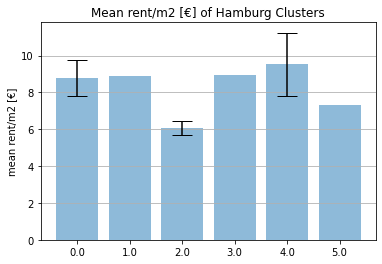

In [77]:
clusterMeanRent(hamburg_merged2, clusters2_sorted, "Cluster Labels")

#### Let's go through the clusters one by one from biggest to smallest:

In [78]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[0]) # black

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Alsterdorf,10.72,53.610541,10.003889,4.0,food_grocery_,asian_,pet_store_,hotel_,bakery_
4,Altona-Altstadt,10.60,53.549660,9.945352,4.0,food_grocery_,hotel_,pub_,cafe_,pharmacy_
5,Altona-Nord,10.61,53.561400,9.944720,4.0,default_,nightclub_,hotel_,pharmacy_,park_
6,Bahrenfeld,10.09,53.569070,9.905583,4.0,default_,food_grocery_,italian_,pharmacy_,beauty_cosmetic_
7,Barmbek-Nord,9.47,53.598894,10.048100,4.0,food_grocery_,asian_,plaza_,italian_,bakery_
9,Bergedorf,8.36,53.483838,10.210047,4.0,italian_,default_,apparel_,pet_store_,food_grocery_
11,Billbrook,8.38,53.527507,10.086782,4.0,cafe_,hotel_,bbqalt_,zoo_,food_foodcourt_
12,Billstedt,8.04,53.548899,10.122625,4.0,beauty_cosmetic_,default_,stadium_soccer_,german_,discountstore_
13,Billwerder,7.82,53.499188,10.134611,4.0,stadium_soccer_,baseballfield_,gastropub_,zoo_,fishandchips_
14,Blankenese,12.19,53.557500,9.803060,4.0,seafood_,cafe_,default_,hotel_,ferry_pier_


In [79]:
topVenueCategories(hamburg_merged2, clusters2_sorted[0])

Top categories are:
 

1st Most Common Venue 
 cafe_            10
default_          8
food_grocery_     7
german_           5
hotel_            5
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 default_         9
hotel_           7
bakery_          7
food_grocery_    5
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 food_grocery_    8
cafe_            3
fastfood_        3
Name: 3rd Most Common Venue, dtype: int64


In [80]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[1]) # blue

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Barmbek-Süd,10.26,53.579885,10.043251,0.0,food_grocery_,german_,performingarts_theater_,pub_,financial_
10,Bergstedt,8.61,53.673430,10.126876,0.0,food_grocery_,departmentstore_,gym_,bakery_,zoo_
18,Curslack,8.39,53.449068,10.229090,0.0,food_grocery_,performingarts_dancestudio_,field_,food_foodcourt_,food_fishmarket_
19,Dulsberg,8.21,53.582566,10.062929,0.0,food_grocery_,park_,bakery_,bbqalt_,cafe_
24,Eißendorf,8.11,53.450786,9.959685,0.0,greek_,fastfood_,food_grocery_,zoo_,financial_
26,Farmsen-Berne,8.17,53.610043,10.112408,0.0,fastfood_,bakery_,food_grocery_,fishandchips_,food_gourmet_
31,Groß Flottbek,11.38,53.565586,9.879233,0.0,food_grocery_,default_,food_farmersmarket_,bakery_,cafe_
39,Hausbruch,7.47,53.471621,9.885541,0.0,hikingtrail_,medical_,food_grocery_,bedandbreakfast_,halal_
40,Heimfeld,8.06,53.463229,9.942094,0.0,food_grocery_,hotel_,stadium_hockey_,greek_,bakery_
44,Horn,8.51,53.554062,10.088918,0.0,food_grocery_,turkish_,park_,racetrack_,cafe_


In [81]:
topVenueCategories(hamburg_merged2, clusters2_sorted[1])

Top categories are:
 

1st Most Common Venue 
 food_grocery_    14
fishandchips_     1
hotel_            1
greek_            1
hikingtrail_      1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 gym_         2
asian_       2
pharmacy_    2
park_        1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 food_grocery_    4
bakery_          3
default_         2
Name: 3rd Most Common Venue, dtype: int64


In [82]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[2]) # green

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Cranz,6.35,53.537285,9.777929,2.0,german_,zoo_,financial_,food_foodcourt_,food_fishmarket_
58,Moorburg,5.79,53.487800,9.937477,2.0,german_,zoo_,financial_,food_foodcourt_,food_fishmarket_


In [83]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[3]) # purple

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
64,Neuland,8.88,53.468155,10.030961,1.0,coffeeshop_,zoo_,financial_,food_gourmet_,food_foodcourt_


In [84]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[4]) # orange

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
79,Rönneburg,7.3,53.433214,10.006395,5.0,greek_,zoo_,field_,food_foodcourt_,food_fishmarket_


In [85]:
clusterAnalysis(hamburg_merged2, clusters2_sorted[5]) # red

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
102,Wohldorf-Ohlstedt,8.95,53.7019,10.1306,3.0,default_,zoo_,financial_,food_gourmet_,food_foodcourt_


### Analysis:
We can observe a distribution very similar to the approach in 4.1. The biggest cluster contains all inner-city neighbourhoods and also spreads out all over Hamburg. Cafes, food-grocery stores, bakeries and hotels are frequently present. A problem with the higher-level categories retrieved from the icon URL is the category "default", which we cannot asign to a certain venue category.

Neighbourhoods Cranz and Moorburg again have been clustered together, but the cluster in 4.1 that was dominated by german restaurants is not present anymore.

While neighbourhoods Neuland and Wohldorf-Ohlstedt are again each their own cluster, now also Rönneburg has been put into a separate cluster. 

### === 4.2.3 -- Cluster analysis for highest-level venue categories ===

In [86]:
mapHamburg(hamburg_merged3)

Determine order of clusters from biggest to smallest:

In [87]:
clusters3_sorted = sortByClusterCount(hamburg_merged3, "hamburg_merged3")

The ranked order of clusters in dataframe hamburg_merged3 is [0.0, 2.0, 1.0]


Mean rent of cluster 0.0 (44 neighbourhoods):  8.98 +/- 1.28 [€]
Mean rent of cluster 2.0 (36 neighbourhoods):  10.04 +/- 1.93 [€]
Mean rent of cluster 1.0 (15 neighbourhoods):  8.16 +/- 0.84 [€]


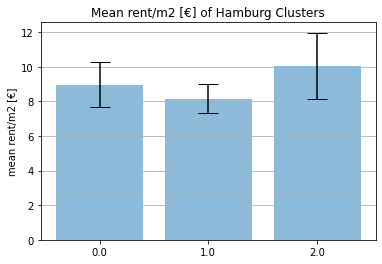

In [88]:
clusterMeanRent(hamburg_merged3, clusters3_sorted, "Cluster Labels")

#### Let's go through the clusters one by one from biggest to smallest:

In [89]:
clusterAnalysis(hamburg_merged3, clusters3_sorted[0]) # black

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Altona-Altstadt,10.60,53.549660,9.945352,0.0,food,shops,travel,nightlife,arts_entertainment
5,Altona-Nord,10.61,53.561400,9.944720,0.0,food,shops,parks_outdoors,nightlife,travel
6,Bahrenfeld,10.09,53.569070,9.905583,0.0,shops,food,parks_outdoors,nightlife,travel
8,Barmbek-Süd,10.26,53.579885,10.043251,0.0,food,shops,travel,nightlife,building
9,Bergedorf,8.36,53.483838,10.210047,0.0,shops,food,travel,building,parks_outdoors
10,Bergstedt,8.61,53.673430,10.126876,0.0,shops,food,building,travel,parks_outdoors
12,Billstedt,8.04,53.548899,10.122625,0.0,shops,food,arts_entertainment,travel,parks_outdoors
16,Bramfeld,8.96,53.616809,10.079001,0.0,shops,food,parks_outdoors,nightlife,travel
18,Curslack,8.39,53.449068,10.229090,0.0,shops,arts_entertainment,travel,parks_outdoors,nightlife
19,Dulsberg,8.21,53.582566,10.062929,0.0,shops,food,parks_outdoors,travel,nightlife


In [90]:
topVenueCategories(hamburg_merged3, clusters3_sorted[0])

Top categories are:
 

1st Most Common Venue 
 shops     29
food      13
travel     2
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 food                  25
shops                 14
travel                 2
arts_entertainment     1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 travel                15
parks_outdoors        13
arts_entertainment     7
Name: 3rd Most Common Venue, dtype: int64


In [91]:
clusterAnalysis(hamburg_merged3, clusters3_sorted[1]) # blue

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Alsterdorf,10.72,53.610541,10.003889,2.0,food,shops,travel,parks_outdoors,nightlife
7,Barmbek-Nord,9.47,53.598894,10.048100,2.0,food,shops,parks_outdoors,travel,arts_entertainment
11,Billbrook,8.38,53.527507,10.086782,2.0,food,travel,shops,parks_outdoors,nightlife
14,Blankenese,12.19,53.557500,9.803060,2.0,food,parks_outdoors,travel,shops,nightlife
15,Borgfelde,9.34,53.555029,10.033300,2.0,food,shops,travel,parks_outdoors,building
17,Cranz,6.35,53.537285,9.777929,2.0,food,travel,shops,parks_outdoors,nightlife
22,Eilbek,9.70,53.566811,10.046703,2.0,food,parks_outdoors,shops,building,travel
23,Eimsbüttel,11.36,53.572937,9.958261,2.0,food,shops,nightlife,parks_outdoors,building
24,Eißendorf,8.11,53.450786,9.959685,2.0,food,shops,travel,parks_outdoors,nightlife
26,Farmsen-Berne,8.17,53.610043,10.112408,2.0,food,shops,travel,parks_outdoors,nightlife


In [92]:
topVenueCategories(hamburg_merged3, clusters3_sorted[1])

Top categories are:
 

1st Most Common Venue 
 food    36
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 shops                 20
travel                10
parks_outdoors         3
arts_entertainment     2
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 travel       12
shops         9
nightlife     5
Name: 3rd Most Common Venue, dtype: int64


In [93]:
clusterAnalysis(hamburg_merged3, clusters3_sorted[2]) # purple

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Billwerder,7.82,53.499188,10.134611,1.0,parks_outdoors,food,arts_entertainment,travel,shops
21,Eidelstedt,8.92,53.605000,9.916110,1.0,parks_outdoors,shops,food,arts_entertainment,travel
39,Hausbruch,7.47,53.471621,9.885541,1.0,travel,shops,parks_outdoors,building,nightlife
49,Kleiner Grasbrook,9.08,53.528549,9.997694,1.0,arts_entertainment,travel,shops,parks_outdoors,nightlife
52,Lemsahl-Mellingstedt,8.92,53.681100,10.086700,1.0,parks_outdoors,shops,food,building,travel
56,Marienthal,9.57,53.565130,10.082381,1.0,travel,shops,parks_outdoors,food,arts_entertainment
60,Neuallermöhe,6.83,53.483349,10.161099,1.0,parks_outdoors,arts_entertainment,travel,shops,nightlife
62,Neuengamme,7.21,53.437905,10.226093,1.0,parks_outdoors,food,arts_entertainment,travel,shops
75,Reitbrook,7.97,53.468845,10.152123,1.0,parks_outdoors,travel,shops,nightlife,food
82,Sinstorf,6.90,53.425263,9.973427,1.0,travel,shops,parks_outdoors,nightlife,food


In [94]:
topVenueCategories(hamburg_merged3, clusters3_sorted[2])

Top categories are:
 

1st Most Common Venue 
 parks_outdoors        10
travel                 3
shops                  1
arts_entertainment     1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 shops                 6
travel                5
food                  2
arts_entertainment    1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 food                  5
shops                 3
arts_entertainment    3
Name: 3rd Most Common Venue, dtype: int64


### Analysis:
For clustering based in highest-level venue categories, we chose only 3 clusters. The largest cluster (black) in this case covers neighbourhoods spread all over Hamburg, but predominantly more at the outskirts. Neighbourhoods are defined by frequency of locations for shopping and eating (shops, food).

The second-largest cluster (blue) is also spread over Hamburg, but covers exclusively the inner city. Here, "food" locations (restaurants, fast food shops) dominate the scene, followed by "travel" locations (such as hotels, hostels), which fits to the image of typical inner-city neighbourhoods with more tourists.

The third cluster (green) is defined by the "parks_outdoors" category. Most of the neighbourhoods can be found farther away from the city center, and there is a higher frequency south of river Elbe. 

## === Part 5: Hamburg Nightlife ===

### In this part, we will have a closer look on nightlife locations in Hamburg. 

This can be interesting for someone who is planning to open a nightclub or bar:
  * where is a certain type of nightlife location over- or underrepresented
  * how is the mean rent in the different locations? It would be not a good idea to open a high-prised cocktail bar in a neighbourhood predominantly occupied by people with low-to-medium income 

We can use the high-level category "nightlife" to look for nightlife locations:

In [95]:
hamburg_venues.loc[hamburg_venues["Highest Category"] == "nightlife"].head(10)

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Higher Category,Highest Category
28,Altona-Altstadt,53.549660,9.945352,Zum Schellfischposten,53.544492,9.946444,Pub,pub_,nightlife
50,Altona-Altstadt,53.549660,9.945352,Haifischbar,53.544333,9.945951,Pub,pub_,nightlife
58,Altona-Altstadt,53.549660,9.945352,Ratsherrn-Eck,53.544382,9.946302,Pub,pub_,nightlife
68,Altona-Nord,53.561400,9.944720,Aalhaus,53.559399,9.946953,Bar,pub_,nightlife
72,Altona-Nord,53.561400,9.944720,Juice Club,53.562922,9.944665,Nightclub,nightclub_,nightlife
82,Altona-Nord,53.561400,9.944720,Stage Club,53.562489,9.948919,Nightclub,nightclub_,nightlife
93,Altona-Nord,53.561400,9.944720,Harkortstraße 125,53.560243,9.939033,Nightclub,nightclub_,nightlife
105,Bahrenfeld,53.569070,9.905583,Gecko-Bar,53.566129,9.907331,Cocktail Bar,cocktails_,nightlife
150,Barmbek-Süd,53.579885,10.043251,Louis Kitchen.Bar,53.578995,10.043755,Bar,pub_,nightlife
259,Bramfeld,53.616809,10.079001,GZeiten,53.617629,10.078561,Bar,pub_,nightlife


Let's safe those venues to a new dataframe:

In [96]:
hamburg_nightlife = hamburg_venues.loc[hamburg_venues["Highest Category"] == "nightlife"]

In [97]:
hamburg_nightlife.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Higher Category,Highest Category
28,Altona-Altstadt,53.54966,9.945352,Zum Schellfischposten,53.544492,9.946444,Pub,pub_,nightlife
50,Altona-Altstadt,53.54966,9.945352,Haifischbar,53.544333,9.945951,Pub,pub_,nightlife
58,Altona-Altstadt,53.54966,9.945352,Ratsherrn-Eck,53.544382,9.946302,Pub,pub_,nightlife
68,Altona-Nord,53.56140,9.944720,Aalhaus,53.559399,9.946953,Bar,pub_,nightlife
72,Altona-Nord,53.56140,9.944720,Juice Club,53.562922,9.944665,Nightclub,nightclub_,nightlife


In [98]:
# show venues types after filtering for "nightlife"
hamburg_nightlife["Venue Category"].unique()

array(['Pub', 'Bar', 'Nightclub', 'Cocktail Bar', 'Dive Bar',
       'Hookah Bar', 'Lounge', 'Irish Pub', 'Beer Bar', 'Beer Garden',
       'Gay Bar', 'Whisky Bar', 'Beer Store', 'Beach Bar'], dtype=object)

Overall, this is a good list of different nightlife locations. Venue Categories are not to detailed, but also not to general. However, there are two problematic categories:
  * Beer Store: this usually means a store where you can by alcoholic drinks late at night (like a 24/7 supermarket), but this is not a spot to spend your time when going out. 
  * Other nightlife: this category encompasses a variety of more niche nightlife spots. Since our clustering algorithm does not know this, this category could skew the analysis.

We therefore drop data with those two categories.

In [99]:
hamburg_nightlife = hamburg_nightlife[hamburg_nightlife["Venue Category"] != "Other Nightlife"]
hamburg_nightlife = hamburg_nightlife[hamburg_nightlife["Venue Category"] != "Beer Store"]
hamburg_nightlife["Venue Category"].unique()

array(['Pub', 'Bar', 'Nightclub', 'Cocktail Bar', 'Dive Bar',
       'Hookah Bar', 'Lounge', 'Irish Pub', 'Beer Bar', 'Beer Garden',
       'Gay Bar', 'Whisky Bar', 'Beach Bar'], dtype=object)

As done previously in part 4, we use one-hot encoding to generate a dataframe with frequencies of different venue categories per neighbourhood:

In [100]:
# one hot encoding
hamburg_night_onehot = pd.get_dummies(hamburg_nightlife[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hamburg_night_onehot['Neighbourhood'] = hamburg_nightlife['Neighbourhood']

# move neighborhood column to the first column
night_fixed_columns = [hamburg_night_onehot.columns[-1]] + list(hamburg_night_onehot.columns[:-1])
hamburg_night_onehot = hamburg_night_onehot[night_fixed_columns]


In [101]:
hamburg_night_onehot.head() # contains all detailed venue categories

,Neighbourhood,Bar,Beach Bar,Beer Bar,Beer Garden,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Irish Pub,Lounge,Nightclub,Pub,Whisky Bar
28,Altona-Altstadt,0,0,0,0,0,0,0,0,0,0,0,1,0
50,Altona-Altstadt,0,0,0,0,0,0,0,0,0,0,0,1,0
58,Altona-Altstadt,0,0,0,0,0,0,0,0,0,0,0,1,0
68,Altona-Nord,1,0,0,0,0,0,0,0,0,0,0,0,0
72,Altona-Nord,0,0,0,0,0,0,0,0,0,0,1,0,0


In [102]:
hamburg_night_grouped = hamburg_night_onehot.groupby('Neighbourhood').mean().reset_index()
hamburg_night_grouped.head()

,Neighbourhood,Bar,Beach Bar,Beer Bar,Beer Garden,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Irish Pub,Lounge,Nightclub,Pub,Whisky Bar
0,Altona-Altstadt,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0
1,Altona-Nord,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
2,Bahrenfeld,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,Barmbek-Süd,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Bramfeld,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


Next, we will define a function to return the top venues categories per location and run it for every location. The result is a data frame.

In [103]:
# create new dataframe with top venue categories
neighborhoods_night_sorted = pd.DataFrame(columns=columns)
neighborhoods_night_sorted["Neighbourhood"] = hamburg_night_grouped["Neighbourhood"]

for ind in np.arange(hamburg_night_grouped.shape[0]):
    neighborhoods_night_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_night_grouped.iloc[ind, :], num_top_venues)

neighborhoods_night_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altona-Altstadt,Pub,Whisky Bar,Nightclub,Lounge,Irish Pub
1,Altona-Nord,Nightclub,Bar,Whisky Bar,Pub,Lounge
2,Bahrenfeld,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
3,Barmbek-Süd,Bar,Whisky Bar,Pub,Nightclub,Lounge
4,Bramfeld,Bar,Whisky Bar,Pub,Nightclub,Lounge


In [104]:
neighborhoods_night_sorted.shape

(24, 6)

Now we try to find the optimal k for k-Means clustering:

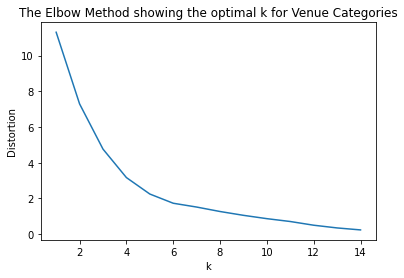

In [105]:
optimalK(hamburg_night_grouped, "Venue Categories", 1, 15)

Again, there is no clear elbow point. Because only ~ 1/5 neighbourhoods returned nightlife locations, I chose to cluster them into 4 clusters.

In [106]:
kmeans_night = clusterKmeans(hamburg_night_grouped, 4)

In [107]:
# checking if labelling worked
kmeans_night.labels_

array([3, 2, 0, 1, 1, 1, 0, 1, 2, 1, 3, 0, 0, 1, 1, 2, 3, 2, 2, 2, 1, 0,
       1, 1])

In [108]:
# add clustering labels to dataframes
neighborhoods_night_sorted.insert(0, 'Cluster Labels', kmeans_night.labels_)

hamburg_nightlife_merged = df_HH_rent_coord

In [109]:
# merge hamburg_grouped with neighborhoods_venues_sorted1-3 to add latitude/longitude for each postal code area
hamburg_nightlife_merged = hamburg_nightlife_merged.join(neighborhoods_night_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [110]:
hamburg_nightlife_merged.head(10)

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allermöhe,8.70,53.483600,10.125000,NaN,NaN,NaN,NaN,NaN,NaN
1,Alsterdorf,10.72,53.610541,10.003889,NaN,NaN,NaN,NaN,NaN,NaN
2,Altengamme,8.00,53.443796,10.273921,NaN,NaN,NaN,NaN,NaN,NaN
3,Altenwerder,9.08,53.504700,9.920560,NaN,NaN,NaN,NaN,NaN,NaN
4,Altona-Altstadt,10.60,53.549660,9.945352,3.0,Pub,Whisky Bar,Nightclub,Lounge,Irish Pub
5,Altona-Nord,10.61,53.561400,9.944720,2.0,Nightclub,Bar,Whisky Bar,Pub,Lounge
6,Bahrenfeld,10.09,53.569070,9.905583,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
7,Barmbek-Nord,9.47,53.598894,10.048100,NaN,NaN,NaN,NaN,NaN,NaN
8,Barmbek-Süd,10.26,53.579885,10.043251,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
9,Bergedorf,8.36,53.483838,10.210047,NaN,NaN,NaN,NaN,NaN,NaN


We drop rows that do not contain any nightlife locations and thus were not clustered:

In [111]:
hamburg_nightlife_merged.dropna(subset=["Cluster Labels"], inplace=True)
hamburg_nightlife_merged

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Altona-Altstadt,10.60,53.549660,9.945352,3.0,Pub,Whisky Bar,Nightclub,Lounge,Irish Pub
5,Altona-Nord,10.61,53.561400,9.944720,2.0,Nightclub,Bar,Whisky Bar,Pub,Lounge
6,Bahrenfeld,10.09,53.569070,9.905583,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
8,Barmbek-Süd,10.26,53.579885,10.043251,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
16,Bramfeld,8.96,53.616809,10.079001,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
23,Eimsbüttel,11.36,53.572937,9.958261,1.0,Bar,Pub,Dive Bar,Whisky Bar,Nightclub
25,Eppendorf,11.83,53.590391,9.986877,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
33,HafenCity,14.40,53.542913,9.995835,1.0,Bar,Cocktail Bar,Whisky Bar,Pub,Nightclub
34,Hamburg-Altstadt,9.57,53.550468,9.994640,2.0,Nightclub,Lounge,Hookah Bar,Cocktail Bar,Whisky Bar
37,Harburg,7.91,53.456222,9.987211,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge


Now we plot the clustered neighbourhoods on the map:

In [112]:
mapHamburg(hamburg_nightlife_merged)

## Analysis:
Most of the neighbourhoods which contained nightlife locations among the top 100 popular venues retrieved from Foursquare are located close to the City Center north of river Elbe.

Now we compare the clusters in more detail:

In [113]:
nightlife_clusters_sorted = sortByClusterCount(hamburg_nightlife_merged, "hamburg_nightlife_merged")

The ranked order of clusters in dataframe hamburg_nightlife_merged is [1.0, 2.0, 0.0, 3.0]


Mean rent of cluster 1.0 (10 neighbourhoods):  10.78 +/- 1.85 [€]
Mean rent of cluster 2.0 (6 neighbourhoods):  10.03 +/- 1.3 [€]
Mean rent of cluster 0.0 (5 neighbourhoods):  11.59 +/- 0.87 [€]
Mean rent of cluster 3.0 (3 neighbourhoods):  11.91 +/- 1.15 [€]


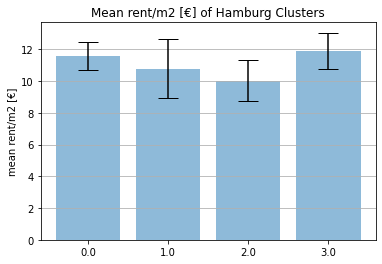

In [114]:
clusterMeanRent(hamburg_nightlife_merged, nightlife_clusters_sorted, "Cluster Labels" )

In [115]:
clusterAnalysis(hamburg_nightlife_merged, nightlife_clusters_sorted[0]) # black

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Barmbek-Süd,10.26,53.579885,10.043251,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
16,Bramfeld,8.96,53.616809,10.079001,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
23,Eimsbüttel,11.36,53.572937,9.958261,1.0,Bar,Pub,Dive Bar,Whisky Bar,Nightclub
33,HafenCity,14.40,53.542913,9.995835,1.0,Bar,Cocktail Bar,Whisky Bar,Pub,Nightclub
37,Harburg,7.91,53.456222,9.987211,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge
65,Neustadt,10.69,53.549881,9.979048,1.0,Bar,Irish Pub,Beer Bar,Whisky Bar,Pub
72,Ottensen,11.60,53.555066,9.919819,1.0,Bar,Pub,Whisky Bar,Nightclub,Lounge
89,Sternschanze,11.73,53.561768,9.963282,1.0,Bar,Nightclub,Lounge,Cocktail Bar,Beach Bar
97,Wandsbek,9.05,53.576003,10.075535,1.0,Hookah Bar,Bar,Whisky Bar,Pub,Nightclub
101,Winterhude,11.83,53.596390,10.003832,1.0,Bar,Whisky Bar,Pub,Nightclub,Lounge


In [116]:
topVenueCategories(hamburg_nightlife_merged, nightlife_clusters_sorted[0])

Top categories are:
 

1st Most Common Venue 
 Bar           9
Hookah Bar    1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Whisky Bar      4
Pub             2
Cocktail Bar    1
Irish Pub       1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Pub           4
Whisky Bar    3
Lounge        1
Name: 3rd Most Common Venue, dtype: int64


In [117]:
clusterAnalysis(hamburg_nightlife_merged, nightlife_clusters_sorted[1]) # blue

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Altona-Nord,10.61,53.561400,9.944720,2.0,Nightclub,Bar,Whisky Bar,Pub,Lounge
34,Hamburg-Altstadt,9.57,53.550468,9.994640,2.0,Nightclub,Lounge,Hookah Bar,Cocktail Bar,Whisky Bar
77,Rothenburgsort,7.79,53.534658,10.036005,2.0,Nightclub,Beer Garden,Whisky Bar,Pub,Lounge
84,St.Georg,11.46,53.557149,10.014256,2.0,Gay Bar,Pub,Hookah Bar,Bar,Whisky Bar
85,St.Pauli,10.93,53.553935,9.959432,2.0,Nightclub,Bar,Pub,Cocktail Bar,Whisky Bar
88,Stellingen,9.81,53.596777,9.928410,2.0,Lounge,Whisky Bar,Pub,Nightclub,Irish Pub


In [118]:
topVenueCategories(hamburg_nightlife_merged, nightlife_clusters_sorted[1])

Top categories are:
 

1st Most Common Venue 
 Nightclub    4
Gay Bar      1
Lounge       1
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Bar            2
Beer Garden    1
Lounge         1
Pub            1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Whisky Bar    2
Pub           2
Hookah Bar    2
Name: 3rd Most Common Venue, dtype: int64


In [119]:
clusterAnalysis(hamburg_nightlife_merged, nightlife_clusters_sorted[2]) # green

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Bahrenfeld,10.09,53.569070,9.905583,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
25,Eppendorf,11.83,53.590391,9.986877,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge
41,Hoheluft-Ost,12.28,53.583434,9.975220,0.0,Cocktail Bar,Pub,Whisky Bar,Nightclub,Lounge
42,Hoheluft-West,11.68,53.580754,9.968331,0.0,Cocktail Bar,Hookah Bar,Whisky Bar,Pub,Nightclub
93,Uhlenhorst,12.07,53.571509,10.012736,0.0,Cocktail Bar,Whisky Bar,Pub,Nightclub,Lounge


In [120]:
topVenueCategories(hamburg_nightlife_merged, nightlife_clusters_sorted[2])

Top categories are:
 

1st Most Common Venue 
 Cocktail Bar    5
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Whisky Bar    3
Hookah Bar    1
Pub           1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Pub           3
Whisky Bar    2
Name: 3rd Most Common Venue, dtype: int64


In [121]:
clusterAnalysis(hamburg_nightlife_merged, nightlife_clusters_sorted[3]) # purple

,Neighbourhood,rent per m2,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Altona-Altstadt,10.60,53.549660,9.945352,3.0,Pub,Whisky Bar,Nightclub,Lounge,Irish Pub
38,Harvestehude,12.72,53.575433,9.980440,3.0,Pub,Whisky Bar,Nightclub,Lounge,Irish Pub
78,Rotherbaum,12.41,53.568407,9.987432,3.0,Pub,Cocktail Bar,Bar,Whisky Bar,Nightclub


In [122]:
topVenueCategories(hamburg_nightlife_merged, nightlife_clusters_sorted[3])

Top categories are:
 

1st Most Common Venue 
 Pub    3
Name: 1st Most Common Venue, dtype: int64 

2nd Most Common Venue 
 Whisky Bar      2
Cocktail Bar    1
Name: 2nd Most Common Venue, dtype: int64 

3rd Most Common Venue 
 Nightclub    2
Bar          1
Name: 3rd Most Common Venue, dtype: int64


## Analysis:
Compared to clustering of neighbourhoods based on popular venues in general (see part 4), clustering based on nightlife locations reveals relatively clear image:
  * Cluster 1 (black): bars (general, whiskey, hookah) dominate the scene
  * Cluster 2 (blue): defined by a high frequency of nightclubs
  * Cluster 0 (green): defined by a high frequency of cocktail bars
  * Cluster 3 (purple): defined by high frequency of pubs
  
This should give someone who wants to open a nightlife location a good starting point to further investigate certain neighbourhoods.